# Belarussian car prices

#### Goal
Predict the price of cars in Belarus using a variety of different regressors. Identify which automobile features have a greater impact on the price.

#### Dataset
The data is a standard text file consisting of comma separated values, available from [Kaggle](https://www.kaggle.com/datasets/osama12bin/cars-csv). The following features are present:
1. Make
2. Model
3. priceUSD
4. year
5. condition
6. mileage(kilometers)
7. fuel_type
8. volume(cm3)
9. color
10. transmission
11. drive_unit
12. segment

There are 56244 records.

#### Methods
This project will follow the usual pattern of data loading, visual inspection of the features, with the final results obtained via the following regressors:
* Decision Tree Regression
* Gradient Boosting Regression

#### Contents
1. [Import Python Modules](#1_import_python_modules)<br>
2. [Preprocess Data 1](#2_preprocess_data_1)<br>
3. [Exploratory Data Analysis](#3_exploratory_data_analysis)<br>
&emsp;3.1 [Categorical Variables](#3_1_categorical_variables)<br>
&emsp;3.2 [Continuous Variables](#3_2_continuous_variables)<br>
4. [Preprocess Data 2](#4_preprocess_data_2)<br>
5. [Regression Approaches](#5_regression_approaches)<br>
&emsp;5.1 [Correlation Heat Map](#5_1_correlation_heat_map)<br>
&emsp;5.2 [DecisionTreeRegressor](#5_2_decisiontreeregressor)<br>
&emsp;5.3 [GradientBoostingRegressor](#5_3_gradientboostingregressor)<br>
6. [Results and Conclusions](#6_results_and_conclusions)<br>

---

<a id="1_import_python_modules"></a>
## 1. Import Python Modules

Top level imports only. This might have a bit of a memory overhead impact, but I feel that the resulting code readability is worthwhile.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as skl

<a id="2_preprocess_data_1"></a>
## 2. Preprocess Data 1

In [3]:
df = pd.read_csv("belarus_car_prices.csv")
df.head(), df.shape, df.dtypes

(    make model  priceUSD  year     condition  mileage(kilometers) fuel_type  \
 0  mazda     2      5500  2008  with mileage             162000.0    petrol   
 1  mazda     2      5350  2009  with mileage             120000.0    petrol   
 2  mazda     2      7000  2009  with mileage              61000.0    petrol   
 3  mazda     2      3300  2003  with mileage             265000.0    diesel   
 4  mazda     2      5200  2008  with mileage              97183.0    diesel   
 
    volume(cm3)     color transmission         drive_unit segment  
 0       1500.0  burgundy    mechanics  front-wheel drive       B  
 1       1300.0     black    mechanics  front-wheel drive       B  
 2       1500.0    silver         auto  front-wheel drive       B  
 3       1400.0     white    mechanics  front-wheel drive       B  
 4       1400.0      gray    mechanics  front-wheel drive       B  ,
 (56244, 12),
 make                    object
 model                   object
 priceUSD                 int64

In [4]:
# the numerical model column & the segment spec will not be used, so drop them
df.drop(columns = ["model","segment"],inplace=True)
df.head()

,make,priceUSD,year,condition,mileage(kilometers),fuel_type,volume(cm3),color,transmission,drive_unit
0,mazda,5500,2008,with mileage,162000.0,petrol,1500.0,burgundy,mechanics,front-wheel drive
1,mazda,5350,2009,with mileage,120000.0,petrol,1300.0,black,mechanics,front-wheel drive
2,mazda,7000,2009,with mileage,61000.0,petrol,1500.0,silver,auto,front-wheel drive
3,mazda,3300,2003,with mileage,265000.0,diesel,1400.0,white,mechanics,front-wheel drive
4,mazda,5200,2008,with mileage,97183.0,diesel,1400.0,gray,mechanics,front-wheel drive


In [5]:
df.nunique()

make                     96
priceUSD               2970
year                     78
condition                 3
mileage(kilometers)    8400
fuel_type                 3
volume(cm3)             458
color                    13
transmission              2
drive_unit                4
dtype: int64

There are 96 unique makes, grouped according to the following:
 - Germany
 - United Kingdom
 - Eastern Bloc
 - Europe
 - Russia & Central Asia
 - Asia (Japan)
 - Asia (not Japan)
 - USA

These categories are an attempt at a manual clustering of these 96 brands according to geographical region & the age of the model. For instance, the buying public will likely make a distinction between Japanese and non-Japanese models in the Asiatic sector. Likewise, old eastern bloc models, such as the Lada, Gaz, Trabant, etc., will likely be in a different space than the more modern (i.e. 2010s and forward) models built in the same countries. Making this disntinction makes sense because, as can be seen further down, that older "Eastern Bloc" models are a significant component of this Belorussian auto market.

In [6]:
df['make'].unique()

array(['mazda', 'mg', 'renault', 'gaz', 'aro', 'rover', 'uaz',
       'alfa-romeo', 'audi', 'oldsmobile', 'saab', 'peugeot', 'chrysler',
       'wartburg', 'moskvich', 'volvo', 'fiat', 'roewe', 'porsche', 'zaz',
       'luaz', 'dacia', 'lada-vaz', 'izh', 'raf', 'bogdan', 'bmw',
       'nissan', 'mercedes-benz', 'mitsubishi', 'toyota', 'chery', 'gmc',
       'hyundai', 'honda', 'ssangyong', 'suzuki', 'opel', 'seat',
       'volkswagen', 'daihatsu', 'chevrolet', 'geely', 'saturn', 'kia',
       'lincoln', 'eksklyuziv', 'citroen', 'dong-feng', 'pontiac', 'ford',
       'subaru', 'bentley', 'faw', 'cadillac', 'lifan', 'plymouth',
       'hafei', 'shanghai-maple', 'mini', 'jeep', 'skoda', 'mercury',
       'changan', 'lexus', 'isuzu', 'aston-martin', 'lancia',
       'great-wall', 'land-rover', 'jaguar', 'buick', 'daewoo', 'vortex',
       'infiniti', 'byd', 'smart', 'maserati', 'haval', 'acura', 'scion',
       'tata', 'datsun', 'tesla', 'mclaren', 'ravon', 'trabant', 'proton',
       'fso

In [7]:
def car_make(make):
    make_euro_de = [
        'audi','bmw','mercedes-benz','opel','porsche','smart','volkswagen'
    ]
    make_euro_uk = [
        'mclaren','bentley','mg','rover','aston-martin','jaguar','land-rover',
        'mini'
    ]
    make_euromain = [
        'lancia','alfa-romeo','peugeot','maserati','renault','dacia','citroen',
        'volvo','fiat','seat','skoda','saab'
    ]
    make_eastern_bloc = [
        'gaz','aro','lada-vaz','izh','raf','moskvich','uaz','luaz','zaz',
        'wartburg','trabant'
    ]
    make_russia_ca = [
        'bogdan', 'fso', 'iran-khodro', 'tagaz','saipa', 'vortex', 'ravon',
        'eksklyuziv'
    ]
    make_asian_japan = [
        'acura','daihatsu','datsun','honda','infiniti','isuzu','lexus','mazda',
        'mitsubishi','nissan','scion','subaru','suzuki','toyota'
    ]
    make_asian_east = [
        'asia','hyundai','ssangyong','kia','daewoo','lifan','hafei','roewe',
        'faw','dong-feng','brilliance','chery','changan','great-wall','byd',
        'geely','haval','jac','zotye','shanghai-maple','tata','proton'
    ]
    make_usa = [
        'buick','cadillac','chevrolet','chrysler','ford','gmc','oldsmobile',
        'plymouth','jeep','mercury','lincoln','saturn','pontiac','tesla'
    ]
    if   make in make_euro_de:      return 'Germany'
    elif make in make_euro_uk:      return 'UK'
    elif make in make_eastern_bloc: return 'Eastern Bloc'
    elif make in make_euromain:     return 'Europe (other)'
    elif make in make_russia_ca:    return 'Russia & Central Asia'
    elif make in make_asian_japan:  return 'Asia (Japan)'
    elif make in make_asian_east:   return 'Asia (not Japan)'
    elif make in make_usa:          return 'USA'

In [8]:
df['make_segment'] = df['make'].apply(car_make)
df['make_segment'].unique()
df.describe()

,priceUSD,year,mileage(kilometers),volume(cm3)
count,56244.000000,56244.000000,5.624400e+04,56197.000000
mean,7415.456440,2003.454840,2.443956e+05,2104.860615
std,8316.959261,8.144247,3.210307e+05,959.201633
min,48.000000,1910.000000,0.000000e+00,500.000000
25%,2350.000000,1998.000000,1.370000e+05,1600.000000
50%,5350.000000,2004.000000,2.285000e+05,1996.000000
75%,9807.500000,2010.000000,3.100000e+05,2300.000000
max,235235.000000,2019.000000,9.999999e+06,20000.000000


In [9]:
df.head()

,make,priceUSD,year,condition,mileage(kilometers),fuel_type,volume(cm3),color,transmission,drive_unit,make_segment
0,mazda,5500,2008,with mileage,162000.0,petrol,1500.0,burgundy,mechanics,front-wheel drive,Asia (Japan)
1,mazda,5350,2009,with mileage,120000.0,petrol,1300.0,black,mechanics,front-wheel drive,Asia (Japan)
2,mazda,7000,2009,with mileage,61000.0,petrol,1500.0,silver,auto,front-wheel drive,Asia (Japan)
3,mazda,3300,2003,with mileage,265000.0,diesel,1400.0,white,mechanics,front-wheel drive,Asia (Japan)
4,mazda,5200,2008,with mileage,97183.0,diesel,1400.0,gray,mechanics,front-wheel drive,Asia (Japan)


<a id="3_exploratory_data_analysis"></a>
## 3. Exploratory Data Analysis

<a id="3_1_categorical_variables"></a>
### 3.1 Categorical Variables

#### Segment: Car Make

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'Asia (Japan)'),
  Text(1, 0, 'UK'),
  Text(2, 0, 'Europe (other)'),
  Text(3, 0, 'Eastern Bloc'),
  Text(4, 0, 'Germany'),
  Text(5, 0, 'USA'),
  Text(6, 0, 'Asia (not Japan)'),
  Text(7, 0, 'Russia & Central Asia')])

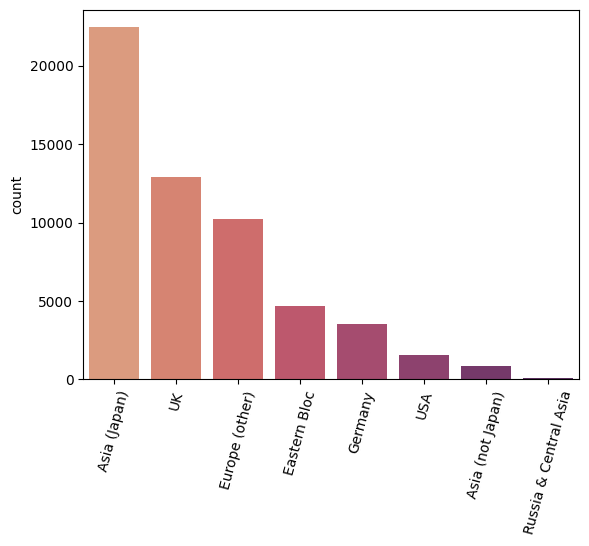

In [10]:
x_data = df['make_segment'].unique()
y_data = df['make_segment'].value_counts()
sns.barplot(x=x_data,y=y_data,palette='flare',hue=x_data,legend=False)
plt.xticks(rotation=75)

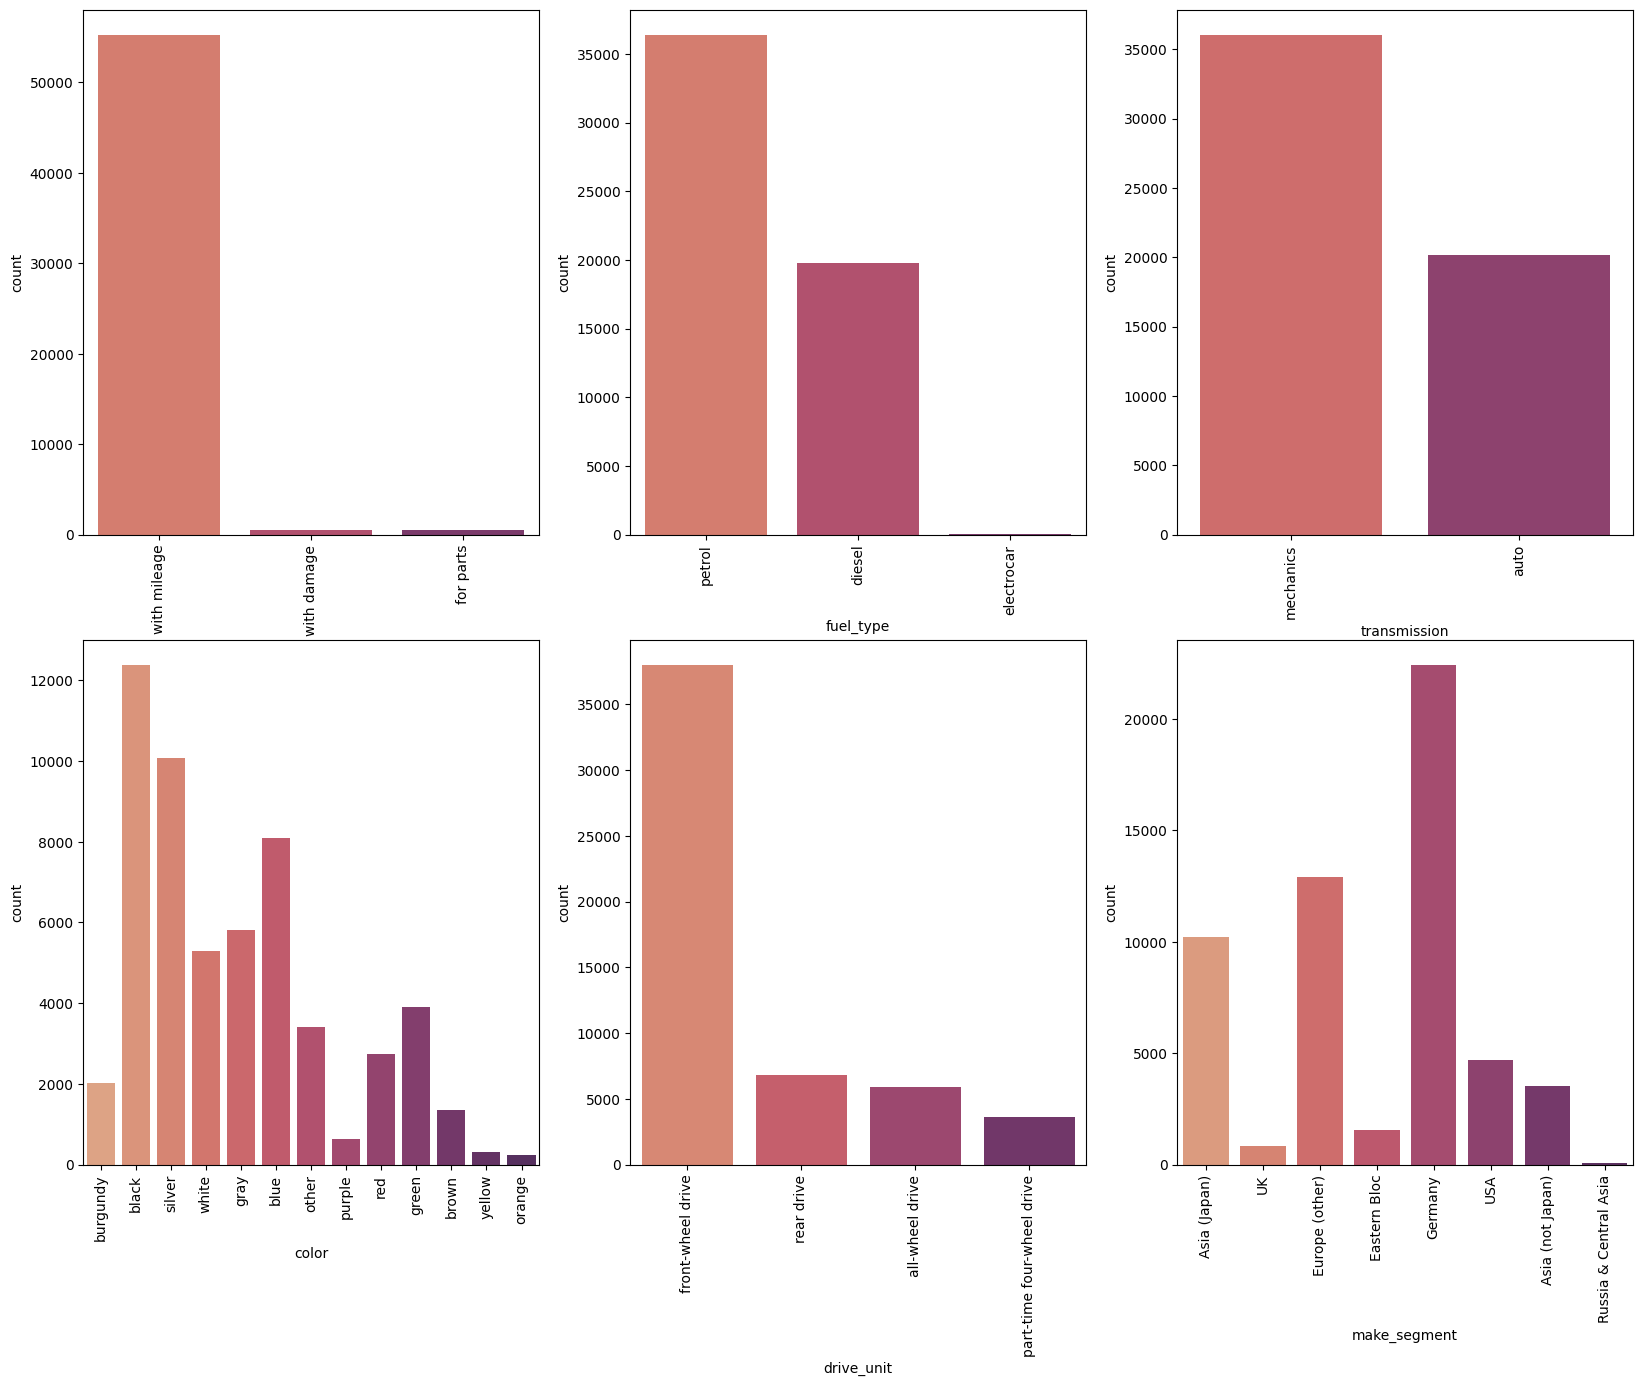

In [11]:
fig, ax = plt.subplots(2,3,figsize=(20,15))
sns.countplot(x='condition',   data=df,palette='flare',hue='condition',   ax=ax[0,0],legend=False)
sns.countplot(x='fuel_type',   data=df,palette='flare',hue='fuel_type',   ax=ax[0,1],legend=False)
sns.countplot(x='transmission',data=df,palette='flare',hue='transmission',ax=ax[0,2],legend=False)
sns.countplot(x='color',       data=df,palette='flare',hue='color',       ax=ax[1,0],legend=False)
sns.countplot(x='drive_unit',  data=df,palette='flare',hue='drive_unit',  ax=ax[1,1],legend=False)
sns.countplot(x='make_segment',data=df,palette='flare',hue='make_segment',ax=ax[1,2],legend=False)
ax[0,0].tick_params(axis='x',rotation=90)
ax[0,1].tick_params(axis='x',rotation=90)
ax[0,2].tick_params(axis='x',rotation=90)
ax[1,0].tick_params(axis='x',rotation=90)
ax[1,1].tick_params(axis='x',rotation=90)
ax[1,2].tick_params(axis='x',rotation=90)

Some observations from the categorical variables:
 - vast majority are in working conditions, although the car condition can be tracked according to miles, damage and whether it is being sold for parts,
 - there is minimum EV penetration in the market,
 - roughly equal numbers of manual and automatic transmission cars,
 - yellow, orange, and purple are unpopular,
 - predominant front wheel drive,
 - German, Japanese, and relatively small European car makers predominate.

It is somewhat surprising that old Eastern Bloc models are not more popular, given their simplicity, low price point, and history in the region. Also noteworthy is the relatively small number of American models. Most of the non-Japanese car makers are Chinese, and it is likely that this sector has increased in the years since this dataset was generated.

<a id="3_2_continuous_variables"></a>
### 3.2 Continuous Variables

<Axes: xlabel='volume(cm3)', ylabel='Count'>

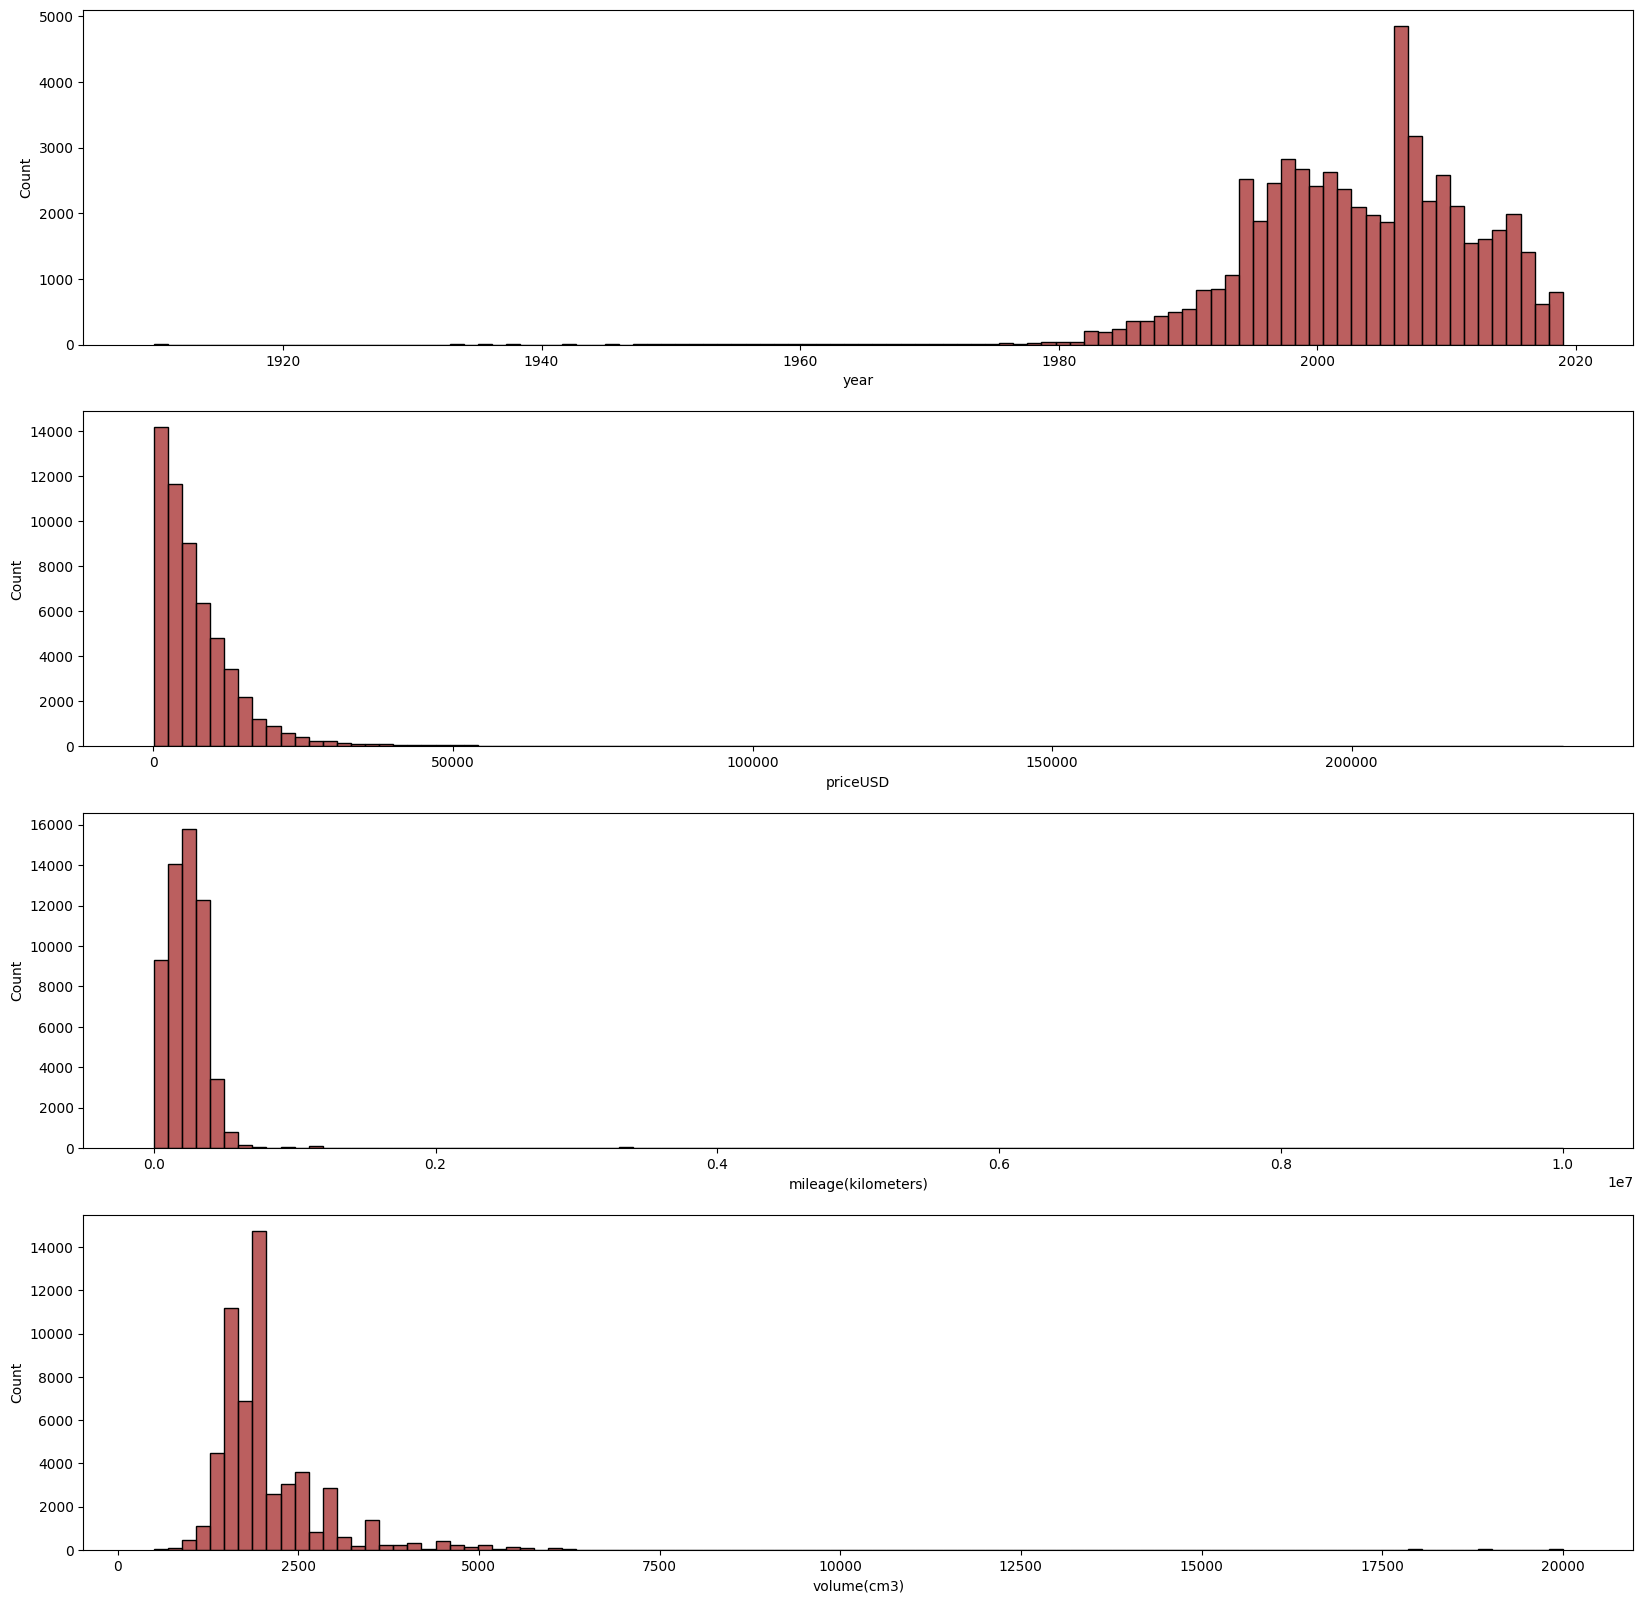

In [14]:
fig, ax = plt.subplots(4,1,figsize=(20,20))
sns.histplot(x='year',               data=df, ax=ax[0], bins=100, color='brown')
sns.histplot(x='priceUSD',           data=df, ax=ax[1], bins=100, color='brown')
sns.histplot(x='mileage(kilometers)',data=df, ax=ax[2], bins=100, color='brown')
sns.histplot(x='volume(cm3)',        data=df, ax=ax[3], bins=100, color='brown')

#### Price and Make

In [15]:
demodf = df.groupby('make')['priceUSD'].mean().reset_index()
demodf = demodf.sort_values(by='priceUSD', ascending=False).head(10)

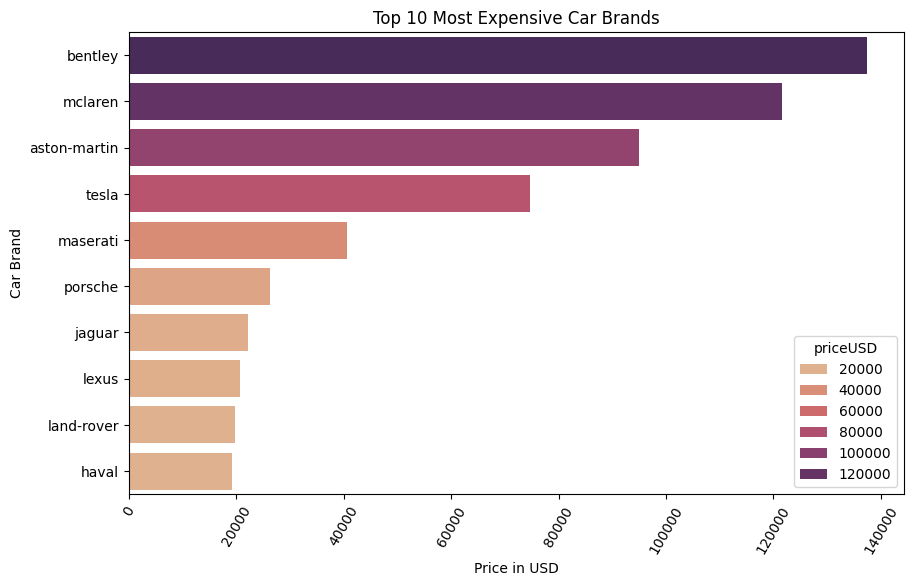

In [16]:
#b Bar Plot
plt.figure(figsize=(10,6))
sns.barplot(y='make',x='priceUSD',palette='flare',hue='priceUSD',data=demodf)
plt.xticks(rotation=60)
plt.title('Top 10 Most Expensive Car Brands')
plt.ylabel('Car Brand')
plt.xlabel('Price in USD')
plt.show()

The main surprise here is that Haval, a relatively unknown Chinese manufacturer, finds itself in this top 10 most expensive list.

#### Price and Condition

According to the dataset there is a dependency of car prices on the following three factors:
 - mileage,
 - damage,
 - whether it is being sold for parts.

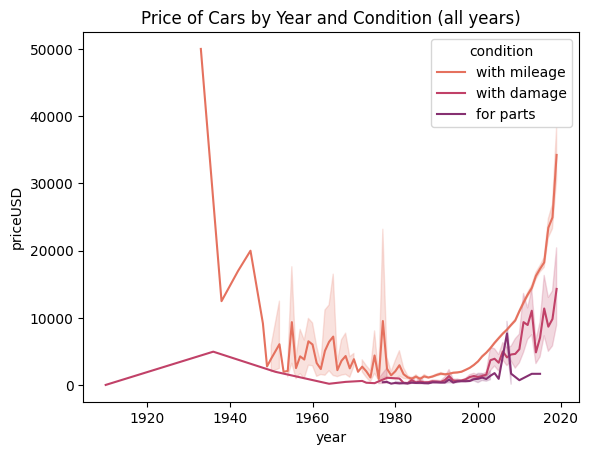

In [17]:
sns.lineplot(data=df,x='year',y='priceUSD',hue='condition',palette='flare')
plt.title('Price of Cars by Year and Condition (all years)')
plt.show()

The dataset presents some problematic behavior prior to 1980:
 - car collectors are probably causing price distortions,
 - extended straight lines ("with damage" data line) indicates a lack of data points,
 - no data for the junkyard vehicles prior to ~1975.

These problems can be removed by dropping all data points prior to 1980 (total of 301 datapoints dropped, 55943 left).

In [18]:
print(df[df['year']<=1980].shape[0])
df1980 = df[df['year']>1980]
print(df1980.shape[0])

301
55943


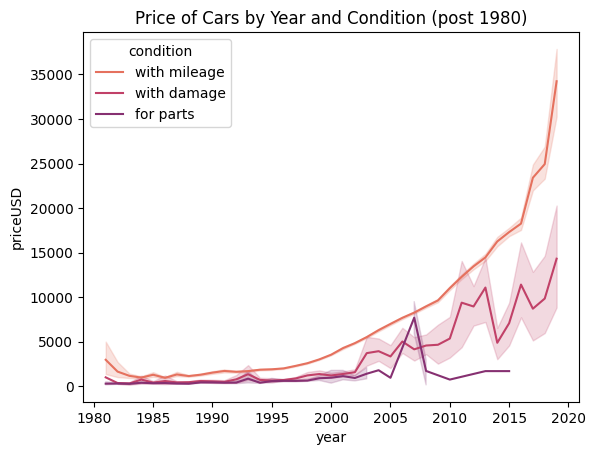

In [19]:
sns.lineplot(data=df1980,x='year',y='priceUSD',hue='condition',palette='flare')
plt.title('Price of Cars by Year and Condition (post 1980)')
plt.show()

This plot can be thought of as describing a form of exponential decay in vehicle prices, if one reverses the direction of the x-axis. As cars get older, they increase in mileage, and become more damaged, resulting in a price drop. A car sold for parts will generally not show much depreciation as a function of time.

#### Price and Transmission

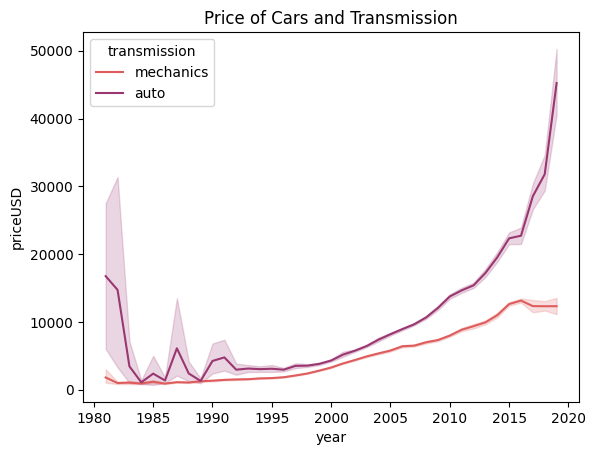

In [20]:
sns.lineplot(x='year',y='priceUSD',data=df1980,hue='transmission',palette='flare')
plt.title('Price of Cars and Transmission')
plt.show()

 - Manual transmission is always less expensive than automatic transmission,
 - Automatic cars have an interesting spike in their prices prior to 1985, suggesting a possible correlation with other factors.

#### Price and Fuel Type

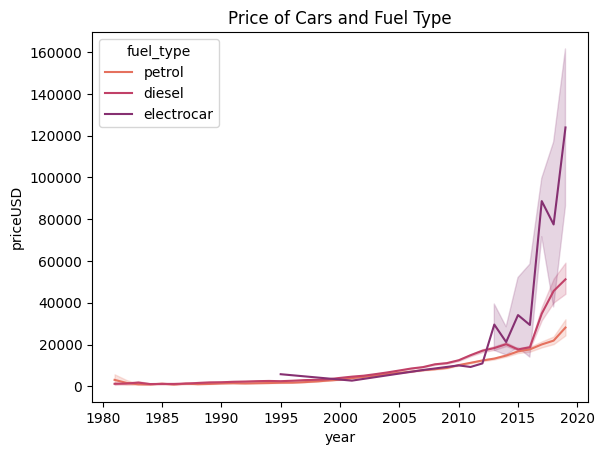

In [21]:
sns.lineplot(x='year',y='priceUSD',data= df1980,hue='fuel_type',palette='flare')
plt.title('Price of Cars and Fuel Type')
plt.show()

 - Prices for all fuel sources are roughly the same till ca. 2012,
 - Electric vehicles show the largest increase after ca. 2012

#### Price and Drive Type

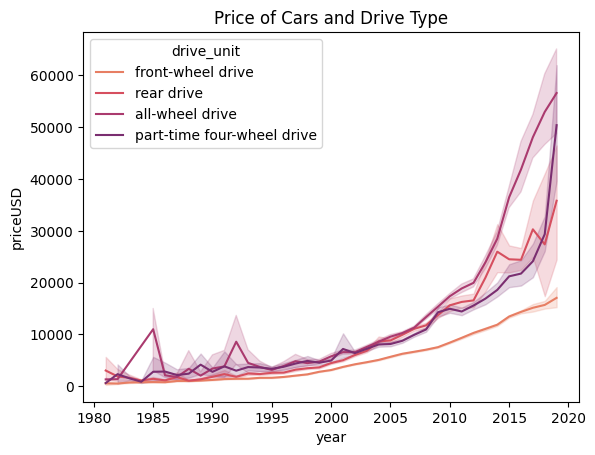

In [22]:
sns.lineplot(x='year',y='priceUSD',data=df1980,hue='drive_unit',palette='flare')
plt.title('Price of Cars and Drive Type')
plt.show()

 - Front wheel drive doesn't result in a price premium
 - Car prices reflect the need for traction during the snowy winters (all-wheel & 4-wheel),
 - Rear wheel drive prices are probably due to their performance characteristics.

#### Price and Brand Segment

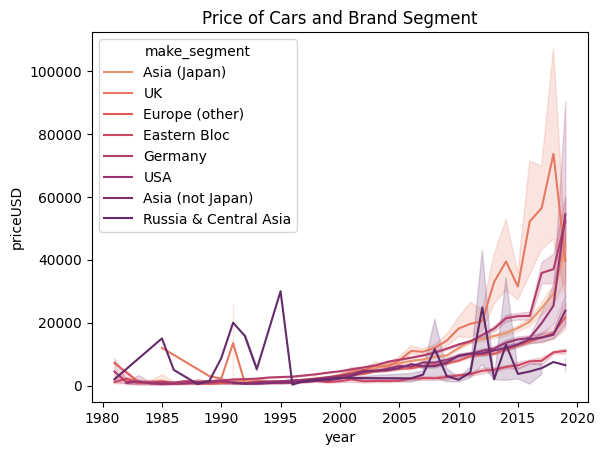

In [23]:
sns.lineplot(x='year',y='priceUSD',data=df1980,hue='make_segment',palette='flare')
plt.title('Price of Cars and Brand Segment')
plt.show()

This plot is a direct result of the manual market segmentation applied above, and as such it can be improved upon by defining different brand segments. Some observations:
 - Steep depreciation curves associated with cars manufactured in Germany and the United Kingdom. This is expected for the associated brands, given their reputation for unreliability.
 - American cars are surprisingly by having similar depreciation characteristics, although they are not as expensive when new.
 - Japanese car depreciation is very similar to American car depreciation
 - Eastern bloc & Russian / Central Asian brands have the best depreciation curves.
 - Chinese brands (pink) are surprising in that they share nearly identical depreciation with the minor European brands (green)

<a id="4_preprocess_data_2"></a>
## 4. Preprocess Data 2

#### Remove null vals

In [24]:
df1980.isnull().sum()

make                      0
priceUSD                  0
year                      0
condition                 0
mileage(kilometers)       0
fuel_type                 0
volume(cm3)              47
color                     0
transmission              0
drive_unit             1874
make_segment              0
dtype: int64

Th total numbers of null values is relatively small, so imputation is not strictly necessary; simply drop them. Also drop the vehicle make column, as this will not be considered in the final analysis

In [25]:
df1980clean = df1980.dropna()
df1980clean = df1980clean.drop(columns=['make'])
df1980clean.columns

Index(['priceUSD', 'year', 'condition', 'mileage(kilometers)', 'fuel_type',
       'volume(cm3)', 'color', 'transmission', 'drive_unit', 'make_segment'],
      dtype='object')

#### Label encoding

In [ ]:
cols = ['condition', 'fuel_type', 'transmission', 'color', 'drive_unit', 'make_segment']
le = skl.preprocessing.LabelEncoder()
for col in cols:
    le.fit(df1980clean[col])
    df1980clean[col] = le.transform(df1980clean[col])
    print(col, df1980clean[col].unique())

condition [2 1 0]
fuel_type [1 0]
transmission [1 0]
color [ 3  0 10 11  4  1  7  8  9  5  2 12  6]
drive_unit [1 3 0 2]
make_segment [0 6 3 2 4 7 1 5]


#### Remove outliers

Use the z-score, a.k.a. the "standard score", which is the number of standard deviations by which a raw value is either above, or below, a certain threshold. This assumes a normal distribution

#### Test-Train split

In [ ]:
X_train, X_test, y_train, y_test = \
skl.model_selection.train_test_split(
    df1980clean.drop(columns=['priceUSD']),
    df1980clean['priceUSD'],
    test_size=0.2,
    random_state=42
)

<a id="5_regression_approaches"></a>
## 5. Regression Approaches

<a id="5_1_correlation_heat_map"></a>
### 5.1 Correlation Heat Map

The `corr()` method invoked below represents a call to an underlying method found in `pandas`. Its default behavior is to calculate the **Pearson Correlation coefficient**, which exists within the domain [-1, 1]. Here I will be assuming that the goal of reporting on which features have the greatest absolute influence on the price; in other words, the sign of the correlation is not taken into account.<br>
A correlation heat map is *not* a regression approach, but I nevertheless include it in this section (Regression Approaches) because it provides information on the impact that individual features have on the automobile price.

<Axes: >

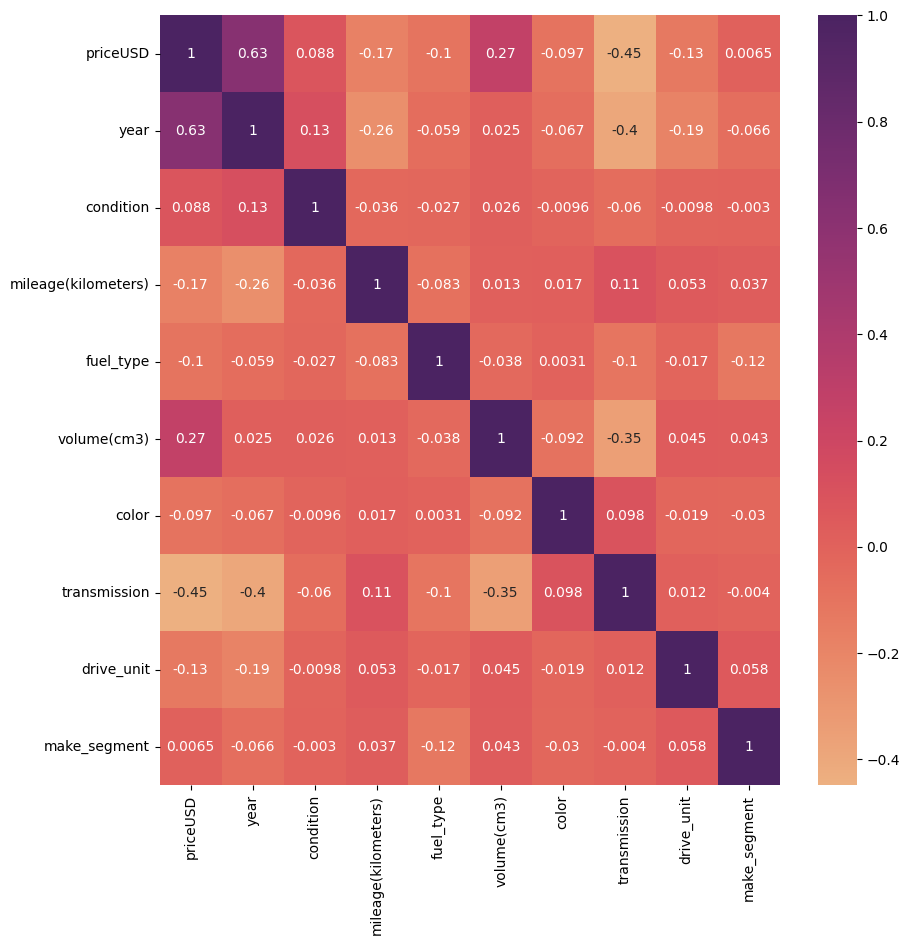

In [29]:
plt.figure(figsize=(10,10))
sns.heatmap(df1980clean.corr(),annot=True,cmap='flare')

In terms of price correlations, the 4 most important features are:
1. Year
2. Transmission
3. Volume
4. Mileage
5. drive_unit

<a id="5_2_decisiontreeregressor"></a>
### 5.2 DecisionTreeRegressor

Decision Tree Regression is appropriate for this type of problem (multiple categorical predictors mapped onto a continuous target) due to the following:
 - the ID3 algorithm has good interpretability and relies only on z-score / standard deviation reduction for leaf node discovery,
 - the goal in this project is to identify which is the best predictor of the target (price), and it is relatively straightforward to permute over the available predictors while identifying which has the greatest standard deviation reduction.

#### Hyperparameter Tuning

In [ ]:
dtr = skl.tree.DecisionTreeRegressor()
params_dtr = {
    'max_depth'        : [15, 16, 17, 18, 20, 21, 22],
    'min_samples_split': [10, 11, 12, 13, 14],
    'min_samples_leaf' : [1, 2, 3, 4, 5, 6],
    'max_features'     : ['sqrt', 'log2'],
    'random_state'     : [41]
}
grid_dtr = skl.model_selection.GridSearchCV(dtr,param_grid=params_dtr,cv=5,verbose=1,n_jobs=-1)
grid_dtr.fit(X_train,y_train)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",DecisionTreeRegressor()
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [15, 16, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [10, 11, ...], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and par

In [32]:
dtr = skl.tree.DecisionTreeRegressor(**grid_dtr.best_params_)
dtr.fit(X_train,y_train,)

,"criterion criterion: {""squared_error"", ""friedman_mse"", ""absolute_error"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in the half mean Poisson deviance to find splits... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 0.24 Poisson deviance criterion.",'squared_error'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.For an example of how ``max_depth`` influences the model, see:ref:`sphx_glr_auto_examples_tree_plot_tree_regression.py`.",18
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",12
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",5
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",41
,"max_

In [33]:
dtr.score(X_train,y_train)

0.873894947916101

#### Model Evaluation

In [34]:
y_pred = dtr.predict(X_test)

In [ ]:
print('R2 Score                :', skl.metrics.r2_score(y_test, y_pred))
print('Mean Squared Error      :', skl.metrics.mean_squared_error(y_test, y_pred))
print('Mean Absolute Error     :', skl.metrics.mean_absolute_error(y_test, y_pred))
print('Root Mean Squared Error :', np.sqrt(skl.metrics.mean_squared_error(y_test, y_pred)))

R2 Score                : 0.822969463427496
Mean Squared Error      : 12118339.981910711
Mean Absolute Error     : 1662.1243317966312
Root Mean Squared Error : 3481.1406150729836


#### Feature Importance

In [36]:
feat_df = pd.DataFrame({'Feature': X_train.columns,'Importance': dtr.feature_importances_})
feat_df = feat_df.sort_values(by='Importance',ascending=False)
feat_df

,Feature,Importance
0,year,0.563568
4,volume(cm3),0.285974
2,mileage(kilometers),0.062393
8,make_segment,0.031979
7,drive_unit,0.021739
6,transmission,0.016000
3,fuel_type,0.011778
5,color,0.006320
1,condition,0.000249


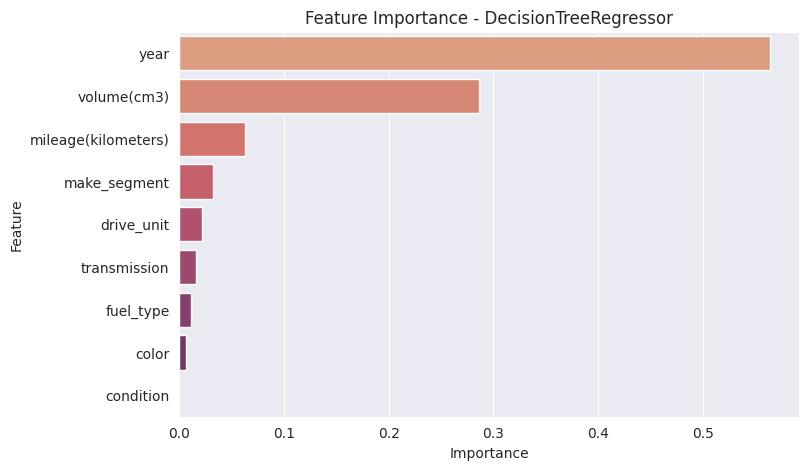

In [31]:
sns.set_style('darkgrid')
plt.figure(figsize=(8,5))
sns.barplot(x='Importance',y='Feature',palette='flare',hue='Feature',data=feat_df)
plt.title('Feature Importance - DecisionTreeRegressor')
plt.show()

<a id="5_3_gradientboostingregressor"></a>
### 5.3 GradientBoostingRegressor

#### Hyperparameter Tuning

In [37]:
gbr = skl.ensemble.GradientBoostingRegressor()
params_gbr = {
    'learning_rate'    : [0.45, 0.50, 0.55, 0.60, 0.65],
    'min_samples_split': [3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_leaf' : [1, 2, 3, 4, 5],
    'max_features'     : ['sqrt', 'log2'],
    'random_state'     : [41]
}
# alternative: use skl.model_selection.RandomizedSearchCV
grid_gbr = skl.model_selection.GridSearchCV(gbr,param_grid=params_gbr,cv=5,verbose=1,n_jobs=-1)
grid_gbr.fit(X_train,y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",GradientBoostingRegressor()
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'learning_rate': [0.45, 0.5, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [3, 4, ...], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fol

In [38]:
gbr = skl.ensemble.GradientBoostingRegressor(**grid_gbr.best_params_)
gbr.fit(X_train,y_train,)

,"loss loss: {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'Loss function to be optimized. 'squared_error' refers to the squarederror for regression. 'absolute_error' refers to the absolute error ofregression and is a robust loss function. 'huber' is acombination of the two. 'quantile' allows quantile regression (use`alpha` to specify the quantile).See:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_quantile.py`for an example that demonstrates quantile regression for creatingprediction intervals with `loss='quantile'`.",'squared_error'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.",0.55
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",100
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are""friedman_mse"" for the mean squared error with improvement score byFriedman, ""squared_error"" for mean squared error. The default value of""friedman_mse"" is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",9
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",4
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",3
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft

In [39]:
gbr.score(X_train,y_train)

0.884254114137231

#### Model Evaluation

In [40]:
y_pred = gbr.predict(X_test)

In [41]:
print('R2 Score                :', skl.metrics.r2_score(y_test, y_pred))
print('Mean Squared Error      :', skl.metrics.mean_squared_error(y_test, y_pred))
print('Mean Absolute Error     :', skl.metrics.mean_absolute_error(y_test, y_pred))
print('Root Mean Squared Error :', np.sqrt(skl.metrics.mean_squared_error(y_test, y_pred)))

R2 Score                : 0.8484207581677349
Mean Squared Error      : 10376112.631683411
Mean Absolute Error     : 1641.2450609078628
Root Mean Squared Error : 3221.197390984199


#### Feature Importance

In [42]:
feat_df = pd.DataFrame({'Feature': X_train.columns,'Importance': gbr.feature_importances_})
feat_df = feat_df.sort_values(by='Importance',ascending=False)
feat_df

,Feature,Importance
0,year,0.526129
4,volume(cm3),0.226243
6,transmission,0.076924
7,drive_unit,0.070298
2,mileage(kilometers),0.058888
8,make_segment,0.019637
3,fuel_type,0.014270
5,color,0.006073
1,condition,0.001538


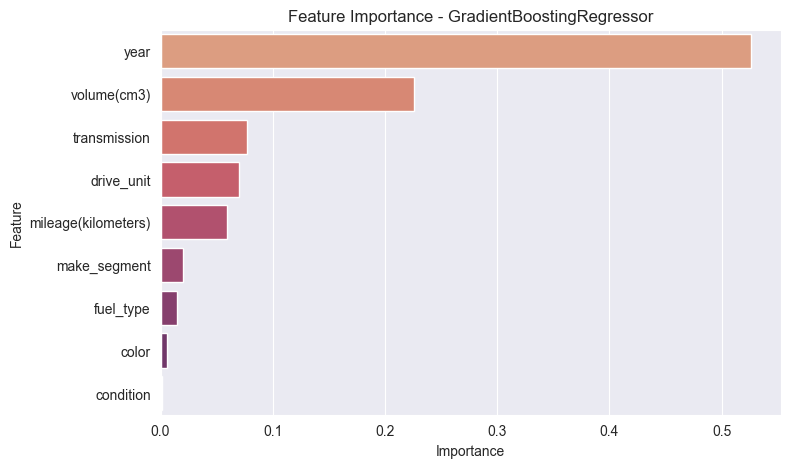

In [43]:
sns.set_style('darkgrid')
plt.figure(figsize=(8,5))
sns.barplot(x='Importance',y='Feature',palette='flare',hue='Feature',data=feat_df)
plt.title('Feature Importance - GradientBoostingRegressor')
plt.show()

<a id="6_results_and_conclusions"></a>
## 6. Results and Conclusions

The following table summarizes the top 5 features, ordered by importance, produced by each of the methods used in the previous section:
| Order | Correlation Matrix | Decision Trees | Gradient Boosting |
|:-----:|:-------------------|:---------------|:------------------|
|1      |year                |year            |year               |
|2      |transmission        |volume          |volume             |
|3      |volume              |mileage         |transmission       |
|4      |mileage             |make_segment    |drive_unit         |
|5      |drive_unit          |drive_unit      |mileage            |

* The model `year` of the vehicle is solidly the most influential feature. All approaches arrived at this conclusion.
* Overall, size of the car (`volume`) and `mileage` are the next most.
* `make_segment` appears only in the top 5 of the DecisionTreeRegressor; here I wonder if there is a different way of clustering the dataset would improve this result.
* Simple correlations might provide *sufficient* insight.
